# Logistic Regression (Binary Classification) of AI/Human-Generated Text 

## First Goal: Gather Data in workable format

### Choice of Datasets: PubMed (Scientific), WritingPrompts(Fiction), CNN_DailyMail(News)

In [1]:
#Get Dependencies
import datasets
import re
import pandas as pd
import os
import random
import tiktoken


In [2]:
# Constants
DATASETS = ['pubmed_qa', 'writingprompts', 'cnn_dailymail']
DATA_PATH = '../data/writingPrompts' 
NUM_EXAMPLES = 150 #Limiting to 150 samples MAX from each dataset due to resource constraints
TAGS = ['[ WP ]', '[ OT ]', '[ IP ]', '[ HP ]', '[ TT ]', '[ Punch ]', '[ FF ]', '[ CW ]', '[ EU ]', '[ CC ]', '[ RF ]',
        '[ wp ]', '[ Wp ]', '[ RF ]', '[ WP/MP ]'] #Need to remove those from WritingPrompts

In [3]:
#Helper Functions 
def strip_newlines(text):
    """
    Removes newline characters from a string.

    Args:
        text (str): Input text string.

    Returns:
        str: Text with newline characters removed.
    """
    return ' '.join(text.split())


def replace_text(text, replacements):
    """
    Performs a series of replacements in a string.

    Args:
        text (str): Input text string.
        replacements (dict): Dictionary mapping old substring to new substring.

    Returns:
        str: Text with specified replacements made.
    """
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

def remove_whitespace_before_punctuations(text):
    """
    Removes whitespace before punctuation marks in a string.

    Args:
        text (str): Input text string.

    Returns:
        str: Text with whitespace removed before punctuation marks.
    """
    return re.sub(r'\s([?.!,:;](?:\s|$))', r'\1', text)



Goal is to have the three datasets in the fromat: [Prompt] [Response]

In [4]:
#Functions to load each dataset, because their format is different.
#Goal is to have the three datasets in the fromat: [Prompt] [Response]
#Where [Prompt] will be used on GPT and Response is the ground truth

def load_pubmed(num_examples=NUM_EXAMPLES):
    """
    Loads the PubMed QA dataset.

    Args:
        num_examples (int, optional): Number of examples to load. Defaults to NUM_EXAMPLES.

    Returns:
        list: List of tuples where each tuple is a question-answer pair and a label (always 0).
    """
    data = datasets.load_dataset('pubmed_qa', 'pqa_labeled', split=f'train[:{num_examples}]')
    data = [(f'Question: {q} Answer: {a}', 0) for q, a in zip(data['question'], data['long_answer'])]
    return data



def load_writingPrompts(data_path=DATA_PATH, num_examples=NUM_EXAMPLES):
    """
    Loads the WritingPrompts dataset. Combines Prompts and Stories with additional formatting.

    Args:
        data_path (str, optional): Path to the dataset. Defaults to DATA_PATH.
        num_examples (int, optional): Number of examples to load. Defaults to NUM_EXAMPLES.

    Returns:
        list: List of tuples where each tuple is a prompt-story pair and a label (always 0).
    """
    with open(f'{data_path}/valid.wp_source', 'r', encoding='utf-8') as f:
        prompts = f.readlines()[:num_examples]
    with open(f'{data_path}/valid.wp_target', 'r', encoding='utf-8') as f:
        stories = f.readlines()[:num_examples]

    prompt_replacements = {tag: '' for tag in TAGS}
    prompts = [replace_text(prompt, prompt_replacements) for prompt in prompts]
    prompts = [remove_whitespace_before_punctuations(prompt) for prompt in prompts]

    story_replacements = {
        ' ,': ',',
        ' .': '.',
        ' ?': '?',
        ' !': '!',
        ' ;': ';',
        ' \'': '\'',
        ' ’ ': '\'',
        ' :': ':',
        '<newline>': '\n',
        '`` ': '"',
        ' \'\'': '"',
        '\'\'': '"',
        '.. ': '... ',
        ' )': ')',
        '( ': '(',
        ' n\'t': 'n\'t',
        ' i ': ' I ',
        ' i\'': ' I\'',
        '\\\'': '\'',
        '\n ': '\n',
    }
    stories = [replace_text(story, story_replacements).strip() for story in stories]
    joined = ["Prompt:" + prompt + " Story: " + story for prompt, story in zip(prompts, stories)]
    filtered = [story for story in joined if 'nsfw' not in story.lower()]
    data = [(story, 0) for story in filtered]
    return data






In [5]:
def load_cnn_daily_mail(num_examples=NUM_EXAMPLES):
    """
    Loads the CNN/Daily Mail dataset. Combines article and summary with additional formatting.

    Args:
        num_examples (int, optional): Number of examples to load. Defaults to NUM_EXAMPLES.

    Returns:
        list: List of tuples where each tuple is a summary-article pair and a label (always 0).
    """
    data = datasets.load_dataset('cnn_dailymail', '3.0.0', split=f'train[:{num_examples}]')

    processed_data = []
    for a, s in zip(data['article'], data['highlights']):
        # remove the string and the '--' from the start of the articles
        a = re.sub('^[^-]*--', '', a).strip()

        # remove the string 'E-mail to a friend.' from the articles, if present
        a = a.replace('E-mail to a friend .', '')
        s = s.replace('NEW:', '')
        a = a.replace(
            'Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, '
            'or redistributed.',
            '')

        # remove whitespace before punctuation marks in both article and summary
        a = remove_whitespace_before_punctuations(a)
        s = remove_whitespace_before_punctuations(s)

        processed_data.append((f'Summary: {s} Article: {a}', 0))
        data = processed_data

    return data

In [6]:
def load_data(dataset_name):
    """
       Loads a dataset based on its name.

       Args:
           dataset_name (str): Name of the dataset to load.

       Returns:
           list: List of data from the specified dataset.

       Raises:
           ValueError: If the dataset_name is not recognized.
    """
    if dataset_name == 'pubmed_qa':
        return load_pubmed()
    elif dataset_name == 'writingprompts':
        return load_writingPrompts()
    elif dataset_name == 'cnn_dailymail':
        return load_cnn_daily_mail()
    else:
        raise ValueError(f"Dataset name {dataset_name} not recognized.")

## The preprocessing function called to get the data in the format we want

In [7]:
def preprocess_data(dataset):
    """
        Preprocesses a dataset.

        Args:
            dataset (str): Name of the dataset to preprocess.

        Returns:
            list: List of preprocessed data from the specified dataset.

        Raises:
            ValueError: If the dataset_name is not recognized.
    """
    if dataset not in DATASETS:
        raise ValueError(f"Dataset name {dataset} not recognized.")

    data = load_data(dataset)
    data = list(dict.fromkeys(data))
    data = [(strip_newlines(q).strip(), a) for q, a in data]
    if dataset == 'pubmed_qa':
        print(f"Loaded and pre-processed {len(data)} questions from the dataset {dataset}")  # debug print

    # Getting long-enough prompts, can do the same for the articles as well
    if dataset == 'writingprompts' or dataset == 'cnn_dailymail':
        long_data = [(x, y) for x, y in data if len(x.split()) > 250]
        if len(long_data) > 0:
            data = long_data
        print(f"Loaded and pre-processed {len(data)} prompts/stories[summaries/articles] from the dataset {dataset}")  # debug
        # print

    return data

Additionally - storing the data as .csv

In [8]:
def convert_to_csv(data, dataset_name, directory='Labelled_Data'):
    """
        Converts the data to a DataFrame and saves it to a CSV file in the specified directory.

        Args:
            data (list): List of data to be converted to CSV.
            dataset_name (str): Name of the dataset.
            directory (str, optional): Name of the directory to save the CSV file. Defaults to 'Labelled_Data'.

        Returns:
            None
    """
    # Check if directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Convert data to DataFrame
    df = pd.DataFrame(data, columns=['text', 'label'])

    # Write DataFrame to CSVv
    df.to_csv(f'{directory}/{dataset_name}_Human_data.csv', index=False)

In [9]:
#Want the prompts only in order to feed them to LLM .
def extract_prompt(data, dataset_name):
    """
    Extracts the prompts from a preprocessed dataset.

    Args:
        data (list): Preprocessed data.
        dataset_name (str): Name of the dataset the data is from.

    Returns:
        list: List of extracted prompts.
    """
    prompts = []
    if dataset_name == 'pubmed_qa':
        prompts = [text.split('Answer:')[0] + 'Answer:' for text, label in data]
    elif dataset_name == 'cnn_dailymail':
        # Split the text into article and summary, then only append the summary
        prompts = [
            'Write a news article based on the following summary: ' + text.split('Summary:')[1].split('Article:')[
                0].strip() for text, label in data]
    elif dataset_name == 'writingprompts':
        prompts = [text.replace('Prompt:', '').split('Story:')[0].strip() + ' Continue the story:' for text, label in
                   data]
    return prompts

In [10]:
#Commbines the three datasets into a single .csv file.
#Additional Parameter for extraction of [Prompts] only
def combine_datasets(datasets=DATASETS, extract_prompts=False, directory='Labelled_Data'):
    """
    Combines data from multiple datasets into a single dataset. If specified, extracts prompts based on dataset names,
    and saves the result to a CSV file.

    Args:
        directory: Where the file will be saved
        datasets (list, optional): List of datasets to combine. Defaults to DATASETS.
        extract_prompts (bool, optional): Whether to extract prompts from the combined data. Defaults to False.

    Returns:
        None
    """
    # Initialize a list to store the combined data
    combined_data = []

    # If specified, also store the extracted prompts
    extracted_prompts = [] if extract_prompts else None

    # Load and preprocess data from each dataset
    for dataset in datasets:
        data = preprocess_data(dataset)
        combined_data.extend(data)

        # If specified, extract prompts
        if extract_prompts:
            extracted_prompts.extend(extract_prompt(data, dataset))

    # Shuffle the combined data to ensure a mix of data from all datasets
    # random.shuffle(combined_data)
    # random.shuffle(extracted_prompts) if extract_prompts else None

    # Save the combined data to a CSV file
    convert_to_csv(combined_data, 'combined')

    # If specified, save the extracted prompts to a CSV file
    if extract_prompts:
        df = pd.DataFrame(extracted_prompts, columns=['text'])
        df.to_csv(f'{directory}/prompts.csv', index=False)


Since will be using OpenAI, which costs $ per token - function to get token count

In [11]:
#Function to get estimated token count using TIKTOKEN, provided by OpenAI for accurate token count
def token_count(csv_files):
    """
    Counts the number of tokens in a CSV file.

    Args:
        csv_file (str): Path to the CSV file.

    Returns:
        None
    """

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    for csv_file in csv_files:
        # Load prompts from CSV file
        df = pd.read_csv(csv_file)
        prompts = df['text'].tolist()

        # Initialize a counter for total tokens
        total_tokens = 0

        for prompt in prompts:
            num_tokens = len(encoding.encode(prompt))
            total_tokens += num_tokens

        print(f"File '{csv_file}' has {total_tokens} tokens.")

        # Estimate cost
        if csv_file == 'Labelled_Data/prompts.csv':
            cost = (total_tokens / 1000) * 0.003
            print(f"Estimated cost for '{csv_file}' is ${cost:.2f}")


# Now that functions for pre-processing data are defined can call them to get the data in identical format [Prompt/Response]

In [12]:
#Loading the datasets which we will use for preprocessing
data_pubmed = preprocess_data('pubmed_qa')
data_writingp = preprocess_data('writingprompts')
data_cnndaily = preprocess_data('cnn_dailymail')

Found cached dataset pubmed_qa (C:/Users/atana/.cache/huggingface/datasets/pubmed_qa/pqa_labeled/1.0.0/dd4c39f031a958c7e782595fa4dd1b1330484e8bbadd4d9212e5046f27e68924)


Loaded and pre-processed 150 questions from the dataset pubmed_qa
Loaded and pre-processed 125 prompts/stories[summaries/articles] from the dataset writingprompts


Found cached dataset cnn_dailymail (C:/Users/atana/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


Loaded and pre-processed 139 prompts/stories[summaries/articles] from the dataset cnn_dailymail


In [13]:
print(data_pubmed[0][0])
#List of tuples where the first is the text and the second the label


Question: Do mitochondria play a role in remodelling lace plant leaves during programmed cell death? Answer: Results depicted mitochondrial dynamics in vivo as PCD progresses within the lace plant, and highlight the correlation of this organelle with other organelles during developmental PCD. To the best of our knowledge, this is the first report of mitochondria and chloroplasts moving on transvacuolar strands to form a ring structure surrounding the nucleus during developmental PCD. Also, for the first time, we have shown the feasibility for the use of CsA in a whole plant system. Overall, our findings implicate the mitochondria as playing a critical and early role in developmentally regulated PCD in the lace plant.


# Now we have 2 csv. files the human-generated full dataset and the prompts to be used in a LLM

In [14]:
combine_datasets(extract_prompts=True)

Found cached dataset pubmed_qa (C:/Users/atana/.cache/huggingface/datasets/pubmed_qa/pqa_labeled/1.0.0/dd4c39f031a958c7e782595fa4dd1b1330484e8bbadd4d9212e5046f27e68924)


Loaded and pre-processed 150 questions from the dataset pubmed_qa
Loaded and pre-processed 125 prompts/stories[summaries/articles] from the dataset writingprompts


Found cached dataset cnn_dailymail (C:/Users/atana/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


Loaded and pre-processed 139 prompts/stories[summaries/articles] from the dataset cnn_dailymail


## Combined: 414 Samples - is size OK?

## Now want to some further pre-processing:
### Calculate all the dependent variables (POS-Tags, Perplexities)
### Would also be good practice to proudce summary statistics for each dataset, to gain more insight

In [15]:
#Dependencies
import spacy
from collections import Counter
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
import textstat
import pandas as pd
import tiktoken
from transformers import RobertaTokenizer, RobertaForMaskedLM
from transformers import pipeline


In [16]:
# Constants
nlp = spacy.load('en_core_web_sm')
FUNCTION_WORDS = {'a', 'in', 'of', 'the'}


In [17]:
def remove_prefix(dataset_name, data):
    """
    This function removes a predefined prefix from each text in a given dataset.

    Args:
    dataset_name (str): The name of the dataset.
    data (list of tuples): The data from the dataset. Each element of the list is a tuple, where the first element
    is the text and the second element is its label.

    Returns:
    texts (list): The list of texts after the prefix has been removed.
    labels (list): The list of labels corresponding to the texts.
    """
    texts, labels = zip(*data)

    if dataset_name == 'pubmed_qa':
        texts = [text.split("Answer:", 1)[1].strip() for text in texts]  # Strip the 'Answer:' prefix'
    elif dataset_name == 'writingprompts':
        texts = [text.split("Story:", 1)[1].strip() for text in texts]  # Stripping the 'Story: ' string
    elif dataset_name == 'cnn_dailymail':
        texts = [text.split("Article:", 1)[1].strip() for text in texts]  # Stripping the 'Article: ' string

    return texts, labels

## Just to understand the length of the responses for each dataset

In [18]:
#Just to get a general idea of how long GPT responses should be 
def average_token_count(dataset_name, data):
    """
    Calculates the average number of tokens in the answers of a dataset.

    Returns:
        float: Average number of tokens in the answers of a dataset.
    """
    texts, labels = remove_prefix(dataset_name, data)

    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

    total_tokens = 0

    for text in texts:
        num_tokens = len(encoding.encode(text))
        total_tokens += num_tokens

    average_tokens = total_tokens / len(texts)

    return average_tokens

#PUBMED = 54
#WP = 780
#CNN = 794


In [19]:
average_token_count('pubmed_qa',data_pubmed), average_token_count('writingprompts', data_writingp), average_token_count('cnn_dailymail',data_cnndaily)

(53.60666666666667, 780.552, 793.4604316546763)

In [20]:
#COUNTING THE POS-TAGS USING SPACEY - library made specifically for this
def count_pos_tags_and_special_elements(text):
    # CHECKED
    """
      This function counts the frequency of POS (Part of Speech) tags, punctuation marks, and function words in a given text.
      It uses the SpaCy library for POS tagging.

      Args:
      text (str): The text for which to count POS tags and special elements.

      Returns:
      pos_counts (dict): A dictionary where keys are POS tags and values are their corresponding count.
      punctuation_counts (dict): A dictionary where keys are punctuation marks and values are their corresponding count.
      function_word_counts (dict): A dictionary where keys are function words and values are their corresponding count.

    """
    # Use SpaCy to parse the text
    doc = nlp(text)

    # Create a counter of POS tags
    pos_counts = Counter(token.pos_ for token in doc)

    # Create a counter of punctuation marks
    punctuation_counts = Counter(token.text for token in doc if token.pos_ == 'PUNCT')

    # Create a counter of function words
    function_word_counts = Counter(token.text for token in doc if token.lower_ in FUNCTION_WORDS)

    return dict(pos_counts), dict(punctuation_counts), dict(function_word_counts)

In [21]:
#Also incorporated readability scores
def calculate_readability_scores(text):
    """
    This function calculates the Flesch Reading Ease and Flesch-Kincaid Grade Level of a text using the textstat library.

    Args:
    text (str): The text to score.

    Returns:
    flesch_reading_ease (float): The Flesch Reading Ease score of the text.
    flesch_kincaid_grade_level (float): The Flesch-Kincaid Grade Level of the text.

    """
    flesch_reading_ease = textstat.flesch_reading_ease(text)
    flesch_kincaid_grade_level = textstat.flesch_kincaid_grade(text)

    return flesch_reading_ease, flesch_kincaid_grade_level

In [22]:
def calculate_average_word_length(texts):
    """
     This function calculates the average word length of a list of texts using the SpaCy library.

     Args:
     texts (list): The list of texts.

     Returns:
     (float): The average word length.

    """

    word_lengths = []

    for text in texts:
        doc = nlp(text)
        for token in doc:
            if not token.is_punct:  # ignore punctuation
                word_lengths.append(len(token.text))

    return mean(word_lengths)


In [23]:

def calculate_average_sentence_length(texts):
    # CHEKCED
    """
    This function calculates the average sentence length of a list of texts using the SpaCy library.

    Args:
    texts (list): The list of texts.

    Returns:
    avg_sentence_length (float): The average sentence length.
    """
    sentence_lengths = []

    for text in texts:
        doc = nlp(text)
        for sent in doc.sents:
            sentence_lengths.append(len(sent))

    return mean(sentence_lengths)

In [24]:
def load_model():
    # CHECKED
    """
      This function loads a pre-trained model and its corresponding tokenizer from the Hugging Face model hub.

      Returns:
      model: The loaded model.
      tokenizer: The tokenizer corresponding to the model.

    """
#     model_name = 'allenai/scibert_scivocab_uncased'
#     model = AutoModelForMaskedLM.from_pretrained(model_name)
#     tokenizer = AutoTokenizer.from_pretrained(model_name)

    model_name = 'roberta-base'
    tokenizer = RobertaTokenizer.from_pretrained(model_name)
    model = RobertaForMaskedLM.from_pretrained(model_name)
    return model, tokenizer

# Probably function I am most uncertain of - calculating perplexity

The function tokenizes the input using SciBert, with an imposed restriction of 512 tokens as the model can't handle more


Also, added effect of removing examples with low-quality/garbage content (DetectGPT paper)


Calculates cross-entropy loss against input tokens - how well the model predicted each token.
    
    
    Perplexity is calculated as exponent of the loss obtained from the model.

In [25]:
def calculate_perplexity(text, model, tokenizer):
    # CHECKED
    """
    Calculates the perplexity of a text using a language model and tokenizer.

    Args:
    text (str): The text for which perplexity will be calculated.
    model: The language model used to calculate perplexity.
    tokenizer: The tokenizer used to tokenize the text.

    Returns:
    perplexity (float or None): The calculated perplexity of the text, or None if the text is too long.
    """
    try:
        input_ids = tokenizer.encode(text, return_tensors='pt')
        # Truncate the text if it's too long for the model
        input_ids = input_ids[:, :model.config.max_position_embeddings]

        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            perplexity = torch.exp(loss)
        return perplexity.item()
    except Exception as e:
        print(f"Tokens > 512, ignoring... in calculate_perplexity: {e}")
        return None


## Question: Does it matter what tokenizer I use (SciBERT, RoBERTa) since I use the metric for comparison (perplexity for human-generated vs AI-generated) and not its absolute-value? 

# To produce some summary statistics now:

In [26]:
def load_and_count(dataset_name, data):
    """
       This function loads the texts from the dataset and calculates the frequency of POS tags, punctuation marks,
       and function words.

       Args:
       dataset_name (str): The name of the dataset.
       data (list of tuples): The data from the dataset. Each element of the list is a tuple, where the first element
       is the text and the second element is its label.

       Returns:
       overall_pos_counts (Counter): A Counter object of POS tag frequencies.
       overall_punctuation_counts (Counter): A Counter object of punctuation mark frequencies.
       overall_function_word_counts (Counter): A Counter object of function word frequencies.
    """

    # CHECKED
    # Extract texts
    texts, labels = remove_prefix(dataset_name, data)

    # Calculate POS tag frequencies for the texts
    pos_frequencies, punctuation_frequencies, function_word_frequencies = zip(
        *[count_pos_tags_and_special_elements(text) for text in texts])

    # Then, sum the dictionaries to get the overall frequencies
    overall_pos_counts = Counter()
    for pos_freq in pos_frequencies:
        overall_pos_counts += Counter(pos_freq)

    overall_punctuation_counts = Counter()
    for punct_freq in punctuation_frequencies:
        overall_punctuation_counts += Counter(punct_freq)

    overall_function_word_counts = Counter()
    for function_word_freq in function_word_frequencies:
        overall_function_word_counts += Counter(function_word_freq)

    return overall_pos_counts, overall_punctuation_counts, overall_function_word_counts

In [27]:
def summary_statistics(dataset_name, data):
    # CHECKED
    """
       Calculates various summary statistics for a dataset.

       Args:
       dataset_name (str): The name of the dataset.
       data (dict): The data from the dataset.

       Returns:
       dict: A dictionary containing various summary statistics of the data.
   """
    texts, labels = remove_prefix(dataset_name, data)

    model, tokenizer = load_model()
    overall_pos_counts, overall_punctuation_counts, overall_function_word_counts = load_and_count(dataset_name, data)
    readability_scores = [calculate_readability_scores(text) for text in texts]
    average_flesch_reading_ease = mean(score[0] for score in readability_scores)
    average_flesch_kincaid_grade_level = mean(score[1] for score in readability_scores)
    average_word_length = calculate_average_word_length(texts)
    average_sentence_length = calculate_average_sentence_length(texts)
    text_perplexities = [calculate_perplexity(text, model, tokenizer) for text in texts]
    text_perplexities = [p for p in text_perplexities if p is not None]
    average_text_perplexity = sum(text_perplexities) / len(text_perplexities)
    sentences = [sentence.text for text in texts for sentence in nlp(text).sents]
    sentence_perplexities = [calculate_perplexity(sentence, model, tokenizer) for sentence in sentences]
    sentence_perplexities = [p for p in sentence_perplexities if p is not None]
    average_sentence_perplexity = sum(sentence_perplexities) / len(sentence_perplexities)
    return {
        'pos_freqs': overall_pos_counts,
        'punctuation_freqs': overall_punctuation_counts,
        'function_word_freqs': overall_function_word_counts,
        'average_word_length': average_word_length,
        'average_flesch_reading_ease': average_flesch_reading_ease,
        'average_flesch_kincaid_grade_level': average_flesch_kincaid_grade_level,
        'average_sentence_length': average_sentence_length,
        'average_text_perplexity': average_text_perplexity,
        'average_sentence_perplexity': average_sentence_perplexity,
        'sentence_perplexities': sentence_perplexities,  # added this
        'text_perplexities': text_perplexities  # and this
    }

In [28]:
def print_statistics(statistics):
    # CHECKED
    pos_freqs = statistics['pos_freqs']
    punctuation_freqs = statistics['punctuation_freqs']
    function_word_freqs = statistics['function_word_freqs']

    print(f"Frequency of adjectives: {pos_freqs.get('ADJ', 0)}")
    print(f"Frequency of adverbs: {pos_freqs.get('ADV', 0)}")
    print(f"Frequency of conjunctions: {pos_freqs.get('CCONJ', 0)}")
    print(f"Frequency of nouns: {pos_freqs.get('NOUN', 0)}")
    print(f"Frequency of numbers: {pos_freqs.get('NUM', 0)}")
    print(f"Frequency of pronouns: {pos_freqs.get('PRON', 0)}")
    print(f"Frequency of verbs: {pos_freqs.get('VERB', 0)}")
    print(f"Frequency of commas: {punctuation_freqs.get(',', 0)}")
    print(f"Frequency of fullstops: {punctuation_freqs.get('.', 0)}")
    print(f"Frequency of special character '-': {punctuation_freqs.get('-', 0)}")
    print(f"Frequency of function word 'a': {function_word_freqs.get('a', 0)}")
    print(f"Frequency of function word 'in': {function_word_freqs.get('in', 0)}")
    print(f"Frequency of function word 'of': {function_word_freqs.get('of', 0)}")
    print(f"Frequency of function word 'the': {function_word_freqs.get('the', 0)}")
    print(f"Average Flesch Reading Ease: {statistics['average_flesch_reading_ease']}")
    print(f"Average Flesch-Kincaid Grade Level: {statistics['average_flesch_kincaid_grade_level']}")
    print(f"Average word length: {statistics['average_word_length']}")
    print(f"Average sentence length: {statistics['average_sentence_length']}")
    print(f"Average sentence perplexity: {statistics['average_sentence_perplexity']}")
    print(f"Average text perplexity: {statistics['average_text_perplexity']}")


A paper compared the perplexity distributions ,also GPT-ZERO metions perplexities

In [29]:
def plot_perplexities(sentence_perplexities, text_perplexities):
    """
    Plots Kernel Density Estimates of the sentence and text perplexities.

    Args:
    sentence_perplexities (list of float): The perplexities of the sentences.
    text_perplexities (list of float): The perplexities of the texts.
    """

    # Plot sentence perplexities
    plt.figure(figsize=(12, 6))
    sns.kdeplot(sentence_perplexities, color='skyblue', fill=True)
    plt.title('Density Plot of Sentence Perplexities')
    plt.xlabel('Perplexity')
    plt.xlim(0, 12)  # Limit x-axis to 12 for sentence perplexity
    plt.show()

    # Plot text perplexities
    plt.figure(figsize=(12, 6))
    sns.kdeplot(text_perplexities, color='skyblue', fill=True)
    plt.title('Density Plot of Text Perplexities')
    plt.xlabel('Perplexity')
    plt.xlim(0, 10)  # Limit x-axis to 10 for text perplexity
    plt.show()

In [30]:
stats_pubmed = summary_statistics('pubmed_qa',data_pubmed)
print_statistics(stats_pubmed)

Frequency of adjectives: 914
Frequency of adverbs: 205
Frequency of conjunctions: 216
Frequency of nouns: 1998
Frequency of numbers: 40
Frequency of pronouns: 142
Frequency of verbs: 632
Frequency of commas: 202
Frequency of fullstops: 308
Frequency of special character '-': 82
Frequency of function word 'a': 124
Frequency of function word 'in': 169
Frequency of function word 'of': 283
Frequency of function word 'the': 253
Average Flesch Reading Ease: 29.3832
Average Flesch-Kincaid Grade Level: 14.416
Average word length: 5.654920832039739
Average sentence length: 22.97087378640777
Average sentence perplexity: 1.084736425899765
Average text perplexity: 1.0907774806022643


Reading Ease and Grade Level make sense, since it's a scientifict text.
Manually verified count of POS-tags on a few short examples.

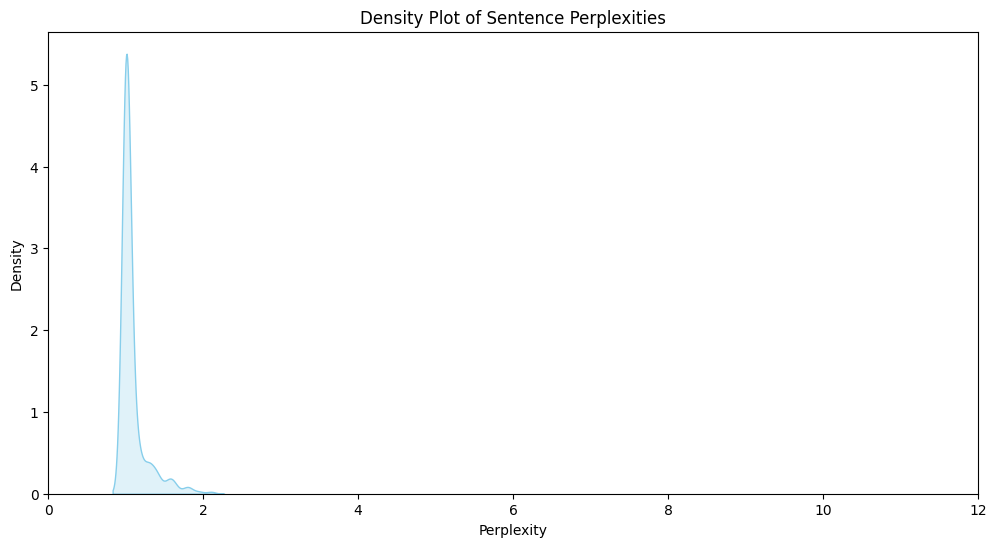

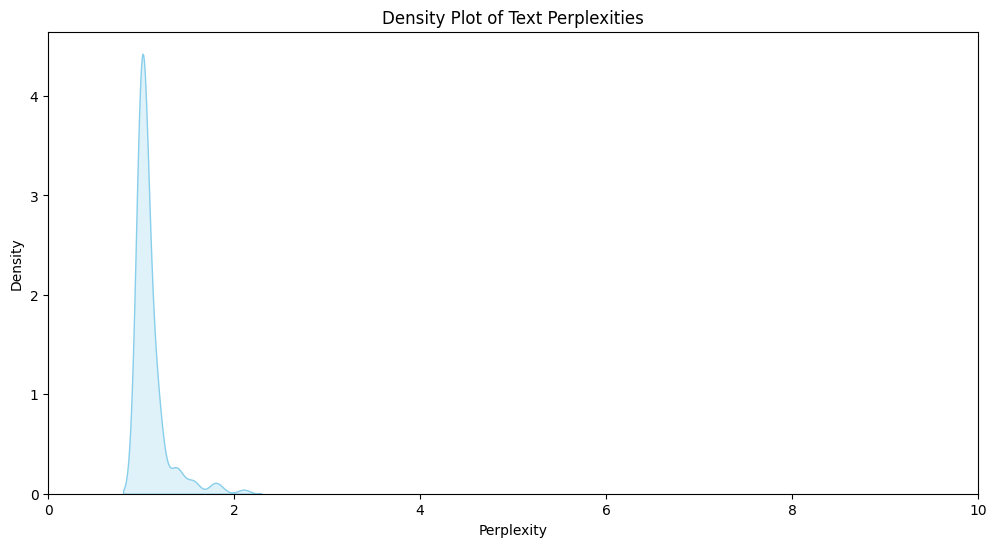

In [31]:
plot_perplexities(stats_pubmed['sentence_perplexities'],stats_pubmed['text_perplexities'])

# Values above are comparable to a paper that performs stats analysis on scientific text

In [32]:
stats_writingp = summary_statistics('writingprompts',data_writingp)


Token indices sequence length is longer than the specified maximum sequence length for this model (658 > 512). Running this sequence through the model will result in indexing errors


Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of 

In [40]:
print_statistics(stats_writingp)

Frequency of adjectives: 4857
Frequency of adverbs: 4771
Frequency of conjunctions: 2615
Frequency of nouns: 13559
Frequency of numbers: 558
Frequency of pronouns: 12770
Frequency of verbs: 12037
Frequency of commas: 4604
Frequency of fullstops: 5440
Frequency of special character '-': 272
Frequency of function word 'a': 1640
Frequency of function word 'in': 899
Frequency of function word 'of': 1524
Frequency of function word 'the': 3500
Average Flesch Reading Ease: 75.1044
Average Flesch-Kincaid Grade Level: 8.3568
Average word length: 4.122463713048104
Average sentence length: 14.347865714719733
Average sentence perplexity: 1.1123606655964569
Average text perplexity: 1.096551609666724


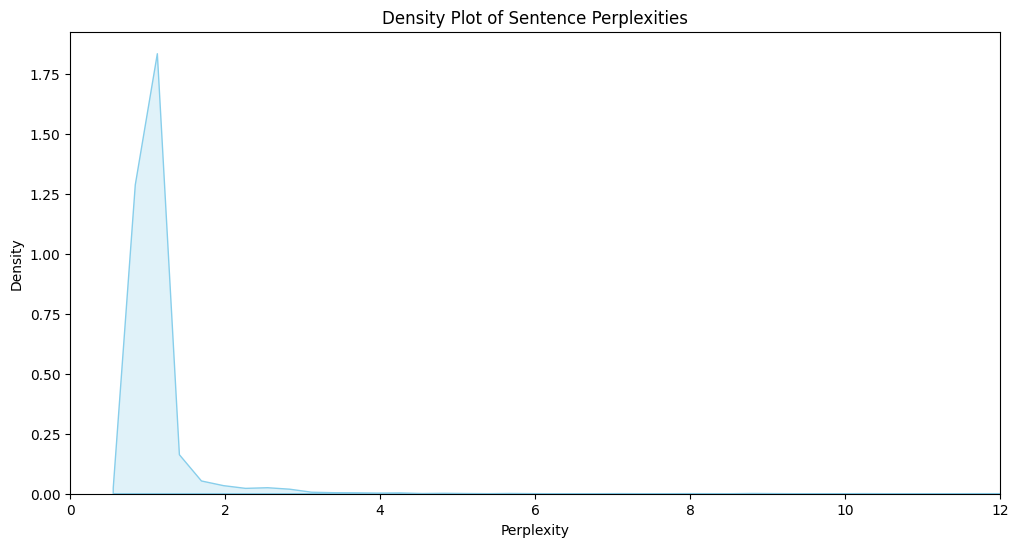

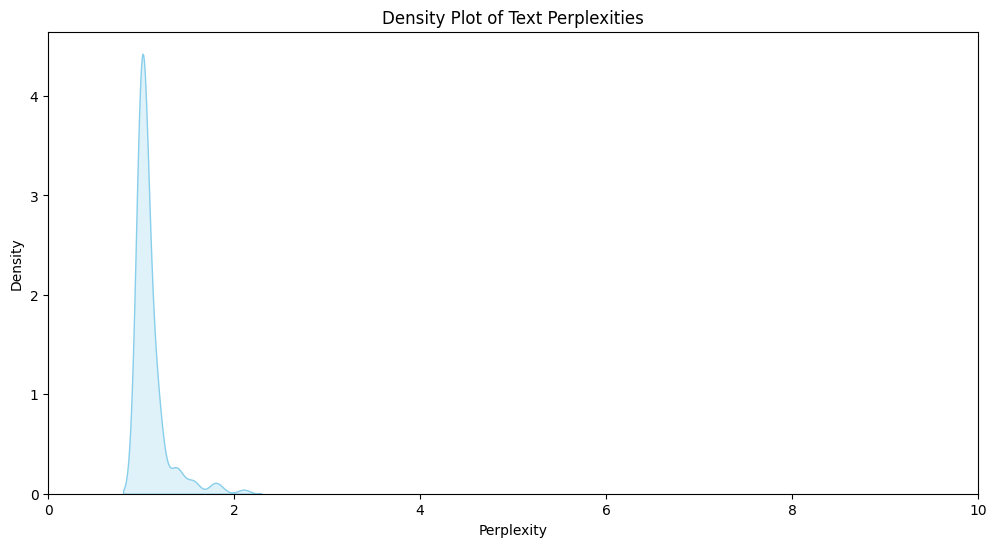

In [33]:
plot_perplexities(stats_writingp['sentence_perplexities'],stats_pubmed['text_perplexities'])

In [34]:
stats_cnndaily = summary_statistics('cnn_dailymail',data_cnndaily)


Token indices sequence length is longer than the specified maximum sequence length for this model (527 > 512). Running this sequence through the model will result in indexing errors


Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of range in self
Tokens > 512, ignoring... in calculate_perplexity: index out of 

Frequency of adjectives: 5591
Frequency of adverbs: 3222
Frequency of conjunctions: 2725
Frequency of nouns: 18393
Frequency of numbers: 2266
Frequency of pronouns: 6282
Frequency of verbs: 11526
Frequency of commas: 4822
Frequency of fullstops: 4400
Frequency of special character '-': 737
Frequency of function word 'a': 1905
Frequency of function word 'in': 1836
Frequency of function word 'of': 2140
Frequency of function word 'the': 4682
Average Flesch Reading Ease: 62.924820143884894
Average Flesch-Kincaid Grade Level: 9.198561151079137
Average word length: 4.680968788229088
Average sentence length: 22.28729162156311
Average sentence perplexity: 1.0361558127439392
Average text perplexity: 1.029602328936259


In [39]:
print_statistics(stats_cnndaily)

Frequency of adjectives: 5591
Frequency of adverbs: 3222
Frequency of conjunctions: 2725
Frequency of nouns: 18393
Frequency of numbers: 2266
Frequency of pronouns: 6282
Frequency of verbs: 11526
Frequency of commas: 4822
Frequency of fullstops: 4400
Frequency of special character '-': 737
Frequency of function word 'a': 1905
Frequency of function word 'in': 1836
Frequency of function word 'of': 2140
Frequency of function word 'the': 4682
Average Flesch Reading Ease: 62.924820143884894
Average Flesch-Kincaid Grade Level: 9.198561151079137
Average word length: 4.680968788229088
Average sentence length: 22.28729162156311
Average sentence perplexity: 1.0361558127439392
Average text perplexity: 1.029602328936259


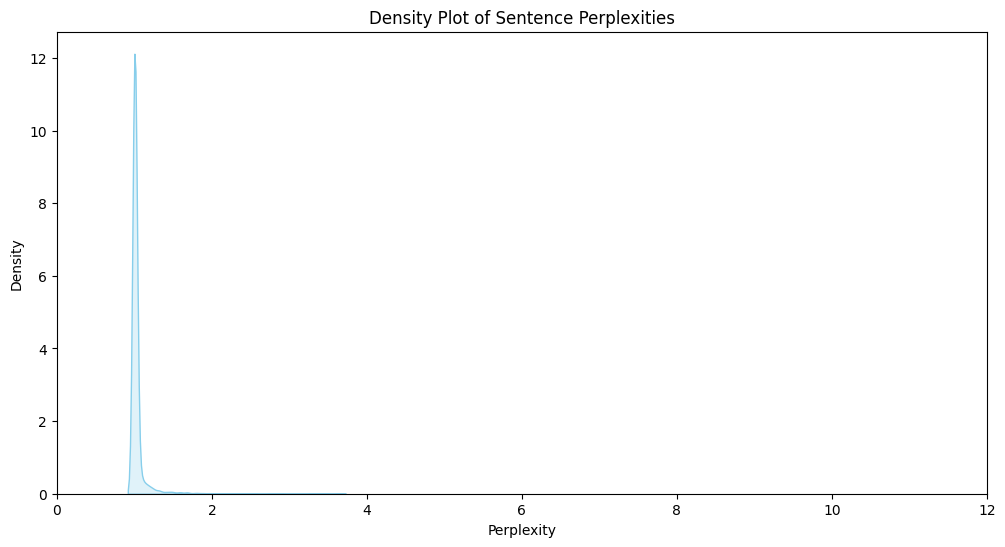

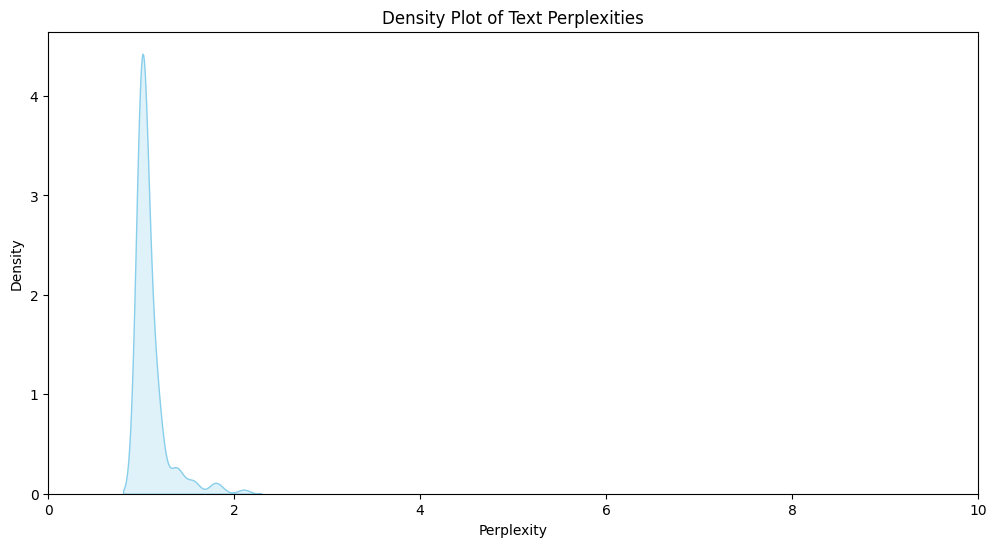

In [35]:
plot_perplexities(stats_cnndaily['sentence_perplexities'],stats_pubmed['text_perplexities'])

## Finally, want to produce a Target Vector and Feature Matrix for the Logistic Regression:

In [36]:
def prepare_data_for_regression(data, dataset_name):
    """
       This function prepares the data for regression analysis by extracting features and labels from the data.

       Args:
       data (list of tuples): The data from the dataset. Each element of the list is a tuple, where the first element
       is the text and the second element is its label.

       Returns:
       feature_matrix (DataFrame): A DataFrame where each row represents a text and each column represents a feature.
       label_vector (Series): A Series where each element is the label of a text.
    """
    # Initialize lists to store features and labels
    feature_list = []
    label_list = []

    # Load the model and tokenizer
    model, tokenizer = load_model()

    # Remove prefixes
    texts, labels = remove_prefix(dataset_name, data)

    for text, label in zip(texts, labels):
        # Count POS tags in the text
        pos_counts, punctuation_counts, function_word_counts = count_pos_tags_and_special_elements(text)

        # Calculate the Flesch Reading Ease and Flesch-Kincaid Grade Level
        flesch_reading_ease, flesch_kincaid_grade_level = calculate_readability_scores(text)

        # Calculate the average word length
        avg_word_length = calculate_average_word_length([text])

        # Calculate the average sentence length
        avg_sentence_length = calculate_average_sentence_length([text])

        # Calculate the perplexity of the text and average sentence perplexity
        text_perplexity = calculate_perplexity(text, model, tokenizer)
        sentence_perplexities = [calculate_perplexity(sentence.text, model, tokenizer) for sentence in nlp(text).sents]
        sentence_perplexities = [p for p in sentence_perplexities if p is not None]
        avg_sentence_perplexity = sum(sentence_perplexities) / len(
            sentence_perplexities) if sentence_perplexities else None

        # Prepare a dictionary to append to the feature list
        features = {**pos_counts, **punctuation_counts, **function_word_counts,
                    'flesch_reading_ease': flesch_reading_ease,
                    'flesch_kincaid_grade_level': flesch_kincaid_grade_level,
                    'avg_word_length': avg_word_length, 'avg_sentence_length': avg_sentence_length,
                    'text_perplexity': text_perplexity, 'avg_sentence_perplexity': avg_sentence_perplexity}

        # Add the feature dictionary and the label to their respective lists
        feature_list.append(features)
        label_list.append(label)

    # Convert the list of dictionaries into a DataFrame
    feature_matrix = pd.DataFrame(feature_list).fillna(0)

    # Convert the list of labels into a Series
    label_vector = pd.Series(label_list)

    return feature_matrix, label_vector

In [37]:
features,target = prepare_data_for_regression(data_pubmed,'pubmed_qa')

In [38]:
print(features.shape)
print(target.shape)

(150, 38)
(150,)


# Next step(s):
## 1. Prompt the API, generate responses, store in a .csv file.
## 2.Calculate Labelled Variables 
## 3.Combine with dataset-data to create training set
## 4.Run the logistic Regression?